In [7]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Protein Folding

### Introduction

The structure and function of many natural and human-engineered
proteins is still only poorly understood. As a result, our understanding of
processes connected with protein folding, such as those encountered in
Alzheimer’s disease, vaccine development, and crop improvement
research, has remained limited.

Unfolded polypeptides have a very large number of degrees of freedom
and thus an enormous number of potential conformations. For example, a
chain with $100$ aminoacids has on the order of $10^{47}$ conformations. In
reality, however, many proteins fold to their native structure within
seconds. This is known as Levinthal’s paradox [1].

The exponential growth of potential conformations with chain length
makes the problem intractable for classical computers. In the quantum
framework, our resource-efficient algorithm scales linearly with
the number of aminoacids N.

The goal of this work is to determine the minimum energy conformation of a protein. Starting from a random configuration, the protein's structure is optimized to lower the energy. This can be achieved by encoding the protein folding problem into a qubit operator and ensuring that all physical constraints are satisfied. 

For the problem encoding we use: 

- Configuration qubits: qubits that are used to describe the configurations and the relative position of the different beads

- Interaction qubits: qubits that encode interactions between the different aminoacids

For our case we use a tetrahedral lattice (diamond shape lattice) where we encode the movement through the configuration qubits (see image below). 

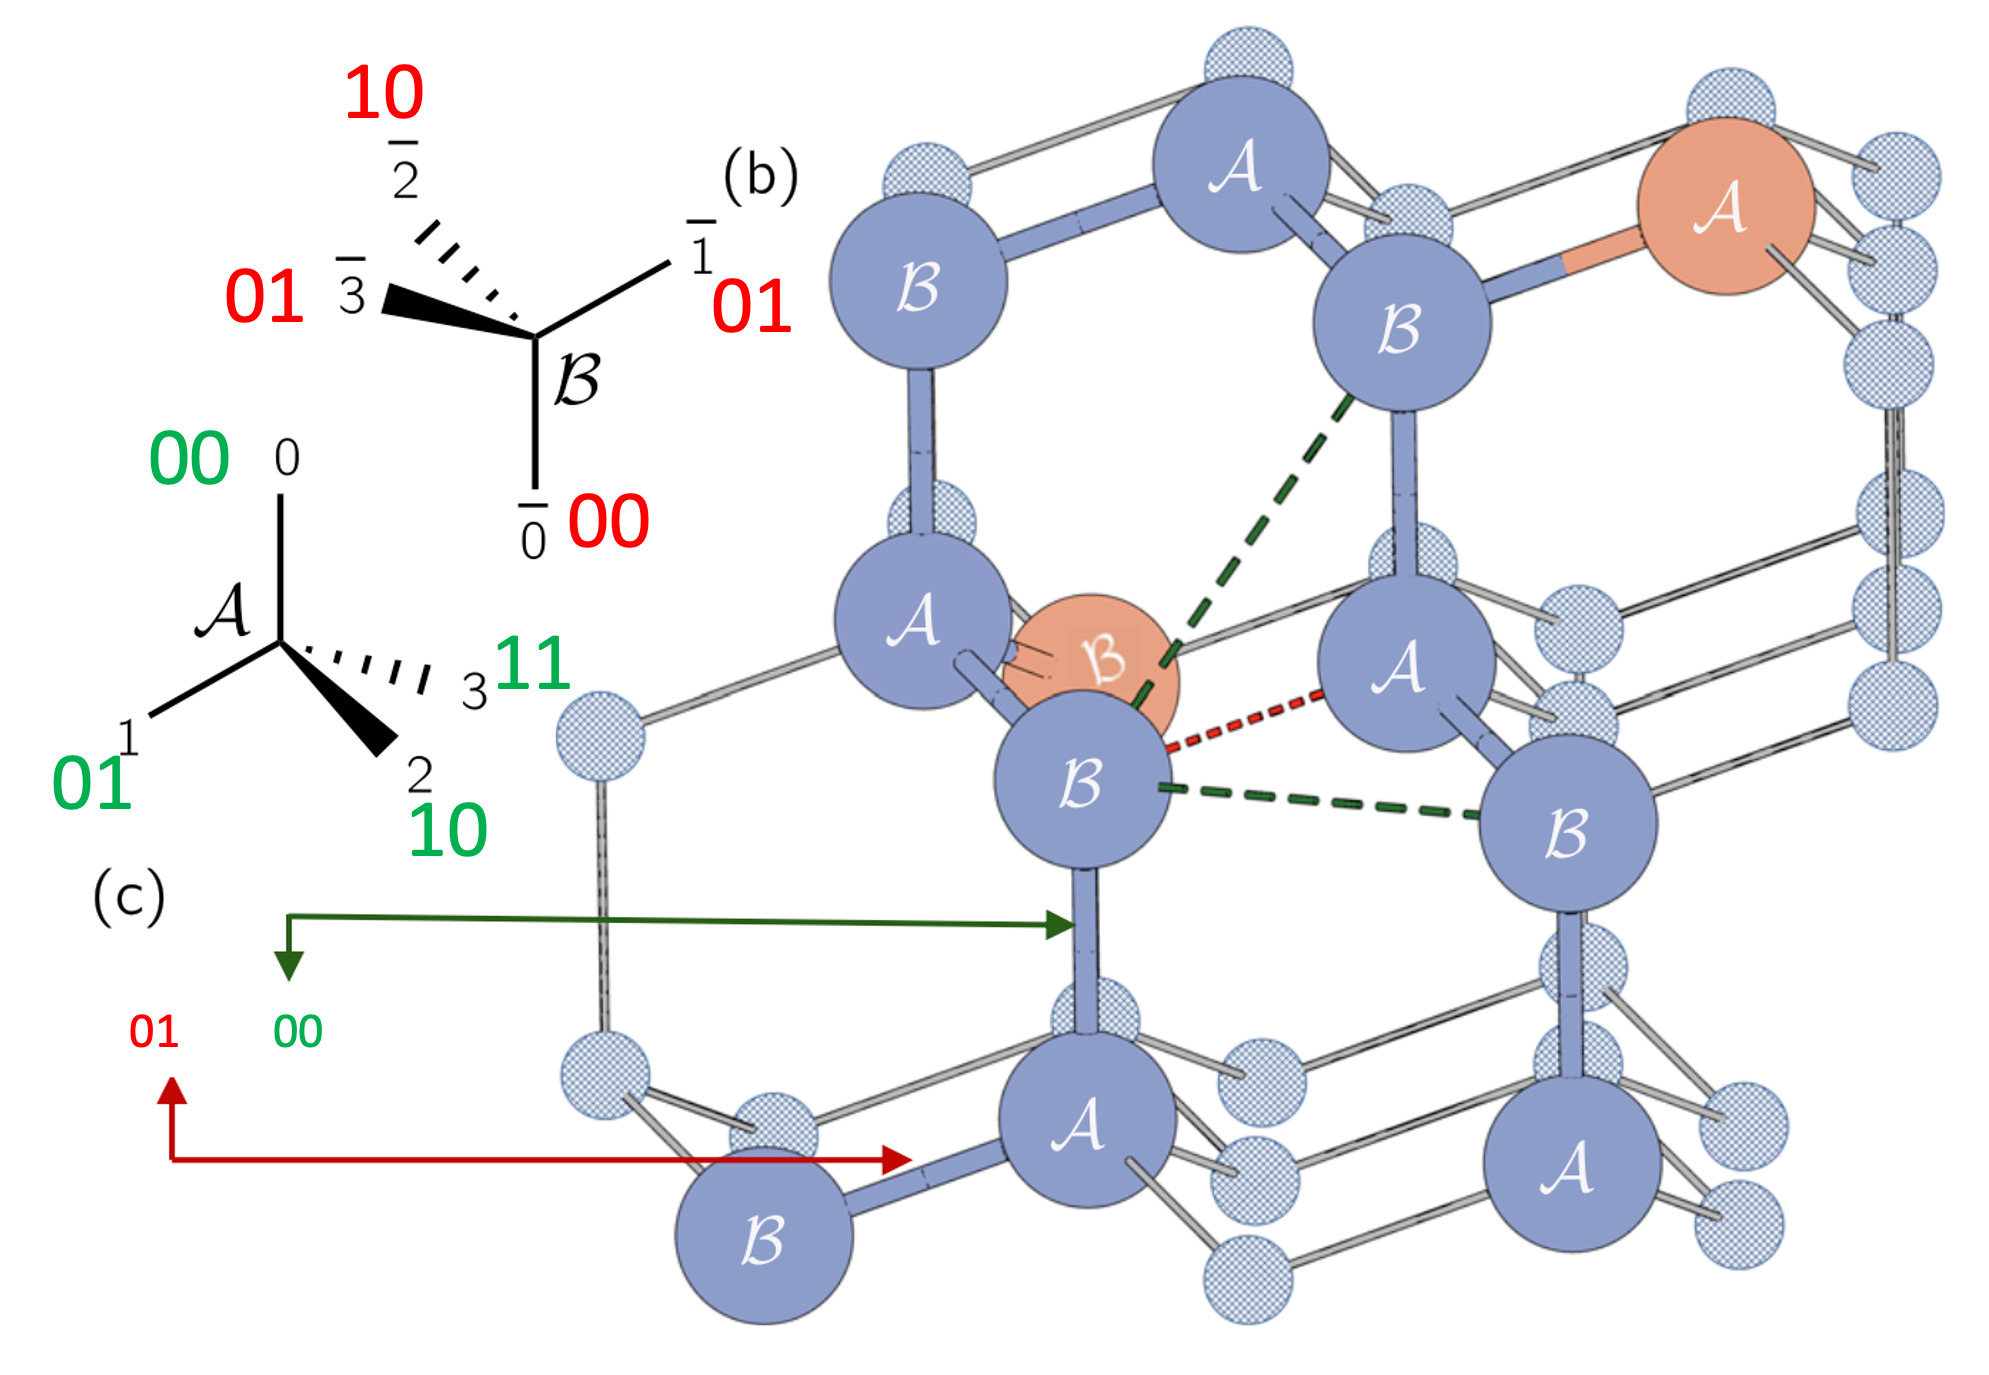

The Hamiltonian of the system for a set of qubits $\mathbf{q}=\{\mathbf{q}_{cf}, \mathbf{q}_{in}\}$ is 

$$H(\mathbf{q}) = H_{gc}(\mathbf{q}_{cf}) + H_{ch}(\mathbf{q}_{cf}) + H_{in}(\mathbf{q}_{cf}, \mathbf{q}_{in}) $$

where 

- $H_{gc}$ is the geometrical constraint term (governing the growth of the primary sequence of aminoacids without bifurcations)

- $H_{ch}$ is the chirality constraint (enforcing the right stereochemistry for the system)

- $H_{in}$ is the interaction energy terms of the system. In our case we consider only nearest neighbor interactions. 

Further details about the used model and the encoding of the problem can be found in [2].

In [8]:
!git clone https://github.com/thepineapplepirate/quantumcomputing_GCC2024.git
!cp -r quantumcomputing_GCC2024/qufold/ .

fatal: destination path 'quantumcomputing_GCC2024' already exists and is not an empty directory.


In [9]:
import sys

sys.path.append("")

from qiskit.circuit.library import RealAmplitudes, EfficientSU2
from qiskit_algorithms import VQE, SamplingVQE
from qiskit_algorithms.optimizers import COBYLA, SLSQP, L_BFGS_B, SPSA
# from qiskit.primitives import Sampler as LocalSampler
from qiskit_aer import AerSimulator
from qiskit_aer.primitives import Sampler, Estimator
import matplotlib.pyplot as plt
import numpy as np
from qufold import (
    MiyazawaJerniganInteraction,
    Peptide,
    ProteinFoldingProblem,
    PenaltyParameters,
)
from qiskit.quantum_info import SparsePauliOp

### Protein Main Chain

The Protein consists of a main chain that is a linear chain of aminoacids. For the naming of different residues we use the one-letter code as defined in Ref. [3]. Further details about the naming and the type of aminoacids can also be found in [4].

For this particular case we demonstrate the generation of the qubit operator in a neuropeptide with the main chain consisting of 7 aminoacids with letter codes APRLRFY (see also [2]).

In [10]:
# define the primary amino acid sequence
main_chain = "LHPGAGK"

### Interaction between Aminoacids

For the description of inter-residue contacts for proteins we use knowledge-based (statistical) potentials derived using quasi-chemical approximation. The potentials used here are introduced by Miyazawa, S. and Jernigan, R. L. in [5]. 

Beyond this model we also allow for random contact maps (interactions) that provide a random interaction map. One can also introduce a custom interaction map that enhances certain configurations of the protein (e.g. alpha helix, beta sheet etc). 

In [12]:
mj_interaction = MiyazawaJerniganInteraction()

### Physical Constraints, Peptide Definition, and the Protein Folding Problem 

To ensure that all physical constraints are respected we introduce penalty functions. The different penalty terms used are: 

- penalty_chiral: A penalty parameter used to impose the right chirality.

- penalty_back: A penalty parameter used to penalize turns along the same axis. This term is used to eliminate sequences where the same axis is chosen twice in a row. In this way we do not allow for a chain to fold back into itself.

- penalty_1: A penalty parameter used to penalize local overlap between beads within a nearest neighbor contact.

Based on the main chain and possible side chains we define the peptide object that includes all the structural information of the modeled system.

Based on the defined peptide, the interaction (contact map) and the penalty terms we defined for our model we define the protein folding problem that returns qubit operators.


In [13]:
def build_pf(main_seq: str):
    """Builds the protein folding problem for the given sequence."""
    # Define the interaction
    side_chains = [""] * len(main_seq)

    mj_interaction = MiyazawaJerniganInteraction()

    penalty_back = 10
    penalty_chiral = 10
    penalty_1 = 10

    penalty_terms = PenaltyParameters(penalty_chiral, penalty_back, penalty_1)

    peptide = Peptide(main_seq, side_chains)

    protein_folding_problem = ProteinFoldingProblem(peptide, mj_interaction, penalty_terms)

    return protein_folding_problem

In [14]:
pf = build_pf(main_chain) #creates the PF problem instance
qubit_op = pf.qubit_op() #creates the problem Hamiltonian
print(qubit_op)

SparsePauliOp(['IIIIIIIII', 'IIIIIIZII', 'IIIIIIIZZ', 'IIIIIIZZZ', 'IIIIZIZII', 'IIIIIZIZI', 'IIIIZZZZI', 'IIZIZIIII', 'IIIZIZIII', 'IIZZZZIII', 'IIIIIIZZI', 'IIIIZIIII', 'IIIIZZIII', 'IIIIIIIIZ', 'IIIIIZIIZ', 'IIIIZZIIZ', 'IZIIIIIII', 'IZIIIIZII', 'IZIIIIZZI', 'IZIIZIIII', 'IZIIZZIII', 'IZIIZIZII', 'IZIIIZIZI', 'IZIIZZZZI', 'IZIIIIIIZ', 'IZIIIIIZZ', 'IZIIIIZZZ', 'IZIIIZIIZ', 'IZIIZZIIZ', 'IIIIIIIZI', 'IIIIIZIII', 'IZIIIIIZI', 'IZIIIZIII', 'IIZIIIIII', 'IIZZIIIII', 'IIZIIIZII', 'IIIZIIIZI', 'IIZZIIZZI', 'IIIZIIIIZ', 'IIZZIIIIZ', 'IZZIIIIII', 'IZZZIIIII', 'IZZIIIZII', 'IZIZIIIZI', 'IZZZIIZZI', 'IZZIZIIII', 'IZIZIZIII', 'IZZZZZIII', 'IZIZIIIIZ', 'IZZZIIIIZ', 'IIIZIIIII', 'ZIIIIIIII', 'ZIIIIIZII', 'ZIIIIIIZI', 'ZIIIIIZZI', 'ZIIIZIIII', 'ZIIIIZIII', 'ZIIIZZIII', 'ZIZIIIIII', 'ZIIZIIIII', 'ZIZZIIIII', 'ZIIIZIZII', 'ZIZIIIZII', 'ZIIIIZIZI', 'ZIIZIIIZI', 'ZIIIZZZZI', 'ZIZZIIZZI', 'ZIZIZIIII', 'ZIIZIZIII', 'ZIZZZZIII', 'ZIIIIIIZZ', 'ZIIIIIZZZ', 'ZIIIIZIIZ', 'ZIIIZZIIZ', 'ZIIZIIIIZ', 'ZIZZIIIIZ

### Using SamplingVQE for the solution of the problem

The problem that we are tackling has now implemented all the physical constraints and has a diagonal Hamiltonian. For the particular case we are targeting the single bitstring that gives us the minimum energy (corresponding to the folded structure of the protein). Thus, we can use the Variational Quantum Eigensolver SamplingVQE (using the sampler primitive) for finding the minimum configuration energy [6] . We use COBYLA for the classical optimization part. One can also use the standard VQE or QAOA algorithm for the solution of the problem.

In [15]:
aer_backend_options = {"device": "CPU"}
estimator = Estimator(backend_options=aer_backend_options)
sampler = Sampler(backend_options=aer_backend_options)

def run_vqe(qubit_op):
    # set classical optimizer
    optimizer = COBYLA(maxiter=150)

    # set variational ansatz
    ansatz = RealAmplitudes(reps=1)

    counts = []
    values = []

    def store_intermediate_result(eval_count, parameters, mean, std):
        counts.append(eval_count)
        values.append(mean)

    vqe = SamplingVQE(
        sampler,
        ansatz=ansatz,
        optimizer=optimizer,
        callback=store_intermediate_result,
    )

    raw_result = vqe.compute_minimum_eigenvalue(qubit_op)

    return raw_result, counts, values

In [16]:
raw_result, counts, values = run_vqe(qubit_op)

/opt/conda/lib/python3.9/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/opt/conda/lib/python3.9/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


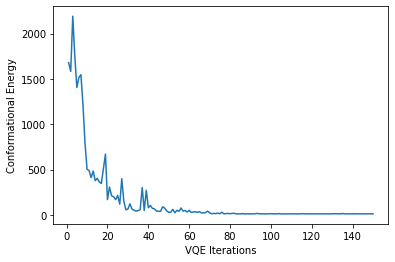

In [17]:
fig = plt.figure()

plt.plot(counts, values)
plt.ylabel("Conformational Energy")
plt.xlabel("VQE Iterations")
plt.show()

### Visualizing the answer

In order to reduce computational costs, we have reduced the problem's qubit operator to the minimum amount of qubits needed to represent the shape of the protein. In order to decode the answer we need to understand how this has been done.
* The shape of the protein has been encoded by a sequence of turns , $\{0,1,2,3\}$. Each turn represents a different direction in the lattice.
* For a main bead of $N_{aminoacids}$ in a lattice, we need $N_{aminoacids}-1$ turns in order to represent its shape. However, the orientation of the protein is not relevant to its energy. Therefore the first two turns of the shape can be set to $[1,0]$ without loss of generality.
* If the second bead does not have any side chain, we can also set the $6^{th}$ qubit to $[1]$ without breaking symmetry.
* Since the length of the secondary chains is always limited to $1$ we only need one turn to describe the shape of the chain.

The total amount of qubits we need to represent the shape of the protein will be $2(N_{aminoacids}-3)$ if there is a secondary chain coming out of the second bead or $2(N_{aminoacids}-3) - 1$, otherwise. All the other qubits will remain unused during the optimization process. See:

In [18]:
result = pf.interpret_new(raw_result)
print(
    "The bitstring representing the shape of the protein during optimization is: ",
    result.turn_sequence,
)
print("The expanded expression is:", result.get_result_binary_vector())

The bitstring representing the shape of the protein during optimization is:  011000101
The expanded expression is: 0______1_____________________________________________________________________________________________________________________________100010_1____


Now that we know which qubits encode which information, we can decode the bitstring into the explicit turns that form the shape of the protein.

In [19]:
print(
    f"The folded protein's main sequence of turns is: {result.protein_shape_decoder.main_turns}"
)
print(f"and the side turn sequences are: {result.protein_shape_decoder.side_turns}")

The folded protein's main sequence of turns is: [1, 0, 3, 1, 0, 1]
and the side turn sequences are: [None, None, None, None, None, None, None]


From this sequence of turns we can get the cartesian coordinates of each of the aminoacids of the protein.

In [20]:
print(result.protein_shape_file_gen.get_xyz_data())

[['L' '0.0' '0.0' '0.0']
 ['H' '2.193931022920578' '2.193931022920578' '-2.193931022920578']
 ['P' '4.387862045841156' '0.0' '-4.387862045841156']
 ['G' '6.581793068761733' '-2.193931022920578' '-2.193931022920578']
 ['A' '4.387862045841155' '-4.387862045841156' '0.0']
 ['G' '2.193931022920577' '-2.193931022920578' '2.193931022920578']
 ['K' '-8.881784197001252e-16' '-4.387862045841156' '4.387862045841156']]


And finally, we can also plot the structure of the protein in 3D. Note that when rendered with the proper backend this plot can be interactively rotated.

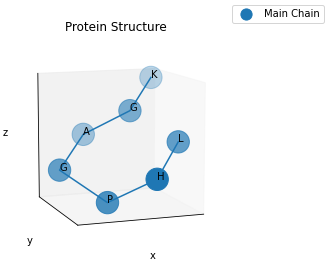

In [21]:
fig = result.get_figure(title="Protein Structure", ticks=False, grid=True)
fig.get_axes()[0].view_init(10, 70)

In [ ]:
result.save_xyz_file(replace=True)
put("{}.xyz".format(main_chain))

### References

<font size='2'>[1] https://en.wikipedia.org/wiki/Levinthal%27s_paradox </font>

<font size='2'>[2] A.Robert, P.Barkoutsos, S.Woerner and I.Tavernelli, Resource-efficient quantum algorithm for protein folding, NPJ Quantum Information, 2021, https://doi.org/10.1038/s41534-021-00368-4 </font>

<font size="2">[3] IUPAC–IUB Commission on Biochemical Nomenclature (1972). "A one-letter notation for aminoacid sequences". Pure and Applied Chemistry. 31 (4): 641–645. doi:10.1351/pac197231040639. PMID 5080161.</font> <br>

<font size="2">[4] https://en.wikipedia.org/wiki/Amino_acid</font>

<font size="2"> [5] S. Miyazawa and R. L.Jernigan, Residue – Residue Potentials with a Favorable Contact Pair Term and an Unfavorable High Packing Density Term for Simulation and Threading, J. Mol. Biol.256, 623–644, 1996, Table 3, https://doi.org/10.1006/jmbi.1996.0114 </font>

<font size="2"> [6] P.Barkoutsos, G. Nannichini, A.Robert, I.Tavernelli, S.Woerner, Improving Variational Quantum Optimization using CVaR, Quantum 4, 256, 2020, https://doi.org/10.22331/q-2020-04-20-256  </font>